In [101]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, copy
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import time
import math, tqdm
import seaborn as sns
from lib.model import MLP, RNN_LSTM, RNN_ILSTM, RNN_SLSTM
from lib.data import FlatData, MNIST_add_data
from lib.utils import timeSince
from lib.train import TrainMLP
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from lib.evaluation import Evaluation, plot_confusion, plot_train_val, plot_train_val_multiple
from lib.data import TwoStateMNISTData
from lib.utils import random_split_dataset
import random
import torch.backends.cudnn as cudnn
import warnings
import glob
from lib.train import Train

# toy testbed

In [12]:
root = './mnist_data'
use_gpu = None
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
trainval_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
train_proportion = 0.8
train_set, val_set = random_split_dataset(trainval_set, [train_proportion, 1-train_proportion])
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

In [13]:
n_hidden = 30 # 50, 300
n_categories = 10
seed = 42

if seed is not None:
    random.seed(seed)
    torch.manual_seed(seed)
    cudnn.deterministic = True
    warnings.warn('You have chosen to seed training. '
                  'This will turn on the CUDNN deterministic setting, '
                  'which can slow down your training considerably! '
                  'You may see unexpected behavior when restarting '
                  'from checkpoints.')
    
'''StateMNISTData vanilla'''
min_length, max_length = 5, 5
target_function = torch.cat([torch.randperm(n_categories).unsqueeze(0) for _ in range(max_length)], 0)

'''ShiftStateMNISTData'''
'''
offset = [-1,3,5,-2,3]
min_length, max_length = 5, 5
'''

/home/jiaxuan/venv/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: You have chosen to seed training. This will turn on the CUDNN deterministic setting, which can slow down your training considerably! You may see unexpected behavior when restarting from checkpoints.
  if __name__ == '__main__':


'\noffset = [-1,3,5,-2,3]\nmin_length, max_length = 5, 5\n'

states: [(0, 0), (1, 7)]
[tensor([1, 2, 0, 8, 5, 6, 3, 9, 4, 7]), tensor([1, 2, 0, 8, 5, 6, 3, 9, 4, 7]), tensor([1, 2, 0, 8, 5, 6, 3, 9, 4, 7])]
tensor([7, 5])


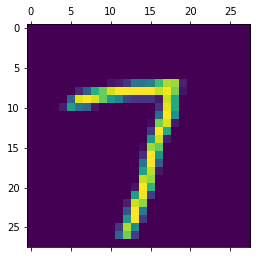

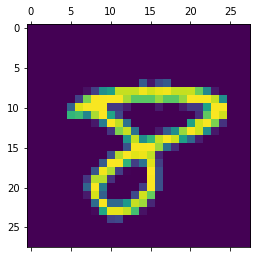

In [136]:
from lib.experiment import PartialSum

ps = PartialSum()
ps.min_length = 1
ps.max_length = 3
ps.share_cycle = 3
ps.set_target_function()

data = ps.gen_data(train_set)
data.debug_mode()
xs, ys = data._random_one()

print(ps.target_function)
print(ys)

for x in xs:
    plt.matshow(x.view(28,28).numpy())
    plt.show()

All data generation are based on StateMNISTData but with differnet target functions. StateMNISTData has state equal to the current time step.

|task             | groups | length | directory     |   memoryless | vanilla  | shared | independent | MoW |
|-------------    | ------ | ------ |-------------  | ----------   | ---------| -------|-------------|-----|
|predict digit    | 5      | 5      | samples       |   yes        | no       | yes    | yes         | yes |
|predict digit    | 3      | 9      | repeat        |   yes        | no       | yes    | maybe       | yes |
|predict digit    | 3      | 1-9    | vary_repeat   |   yes        | no       | yes    | maybe       | yes |
|less data digit  | 3      | 1-9    | scarce        |   yes        | no       | yes    | no          | yes |
|group partial sum| 3      | 1-9    | partial_sum   |   no         | no       | yes    | no          | yes |

Note that shared are always expected to work because it will be given the shared group information. To fail it, simpyly give it wrong sharing information (see repeat b/c there shared is specified as {{0,1,2}, {4,5}, {6,7,8,9}} and it indeed performed worse).


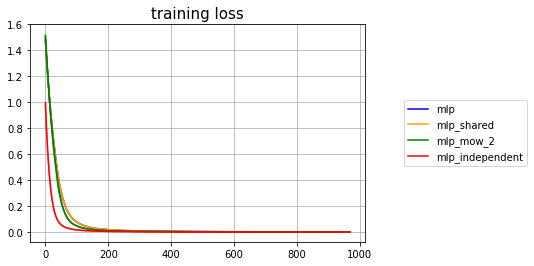

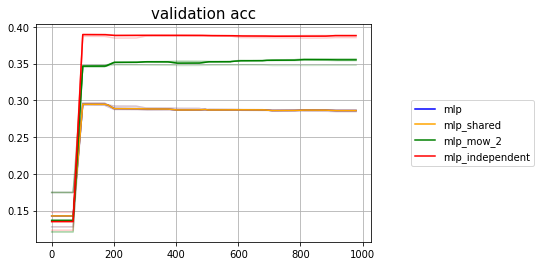

In [199]:
datadir = 'mo_models/partial_sum3_100/*/'

mlp_models = ['mlp.p*',
              'mlp_shared.p*',
              'mlp_mow*.p*',
              'mlp_independent.p*']
rnn_models = ['lstm.p*',
              'lstm_shared.p**',
              'lstm_mow*.p*',
              'lstm_independent.p*']
mlp_models = [os.path.join(datadir, m) for m in mlp_models]
rnn_models = [os.path.join(datadir, m) for m in rnn_models]


plot_train_val_multiple(mlp_models) 

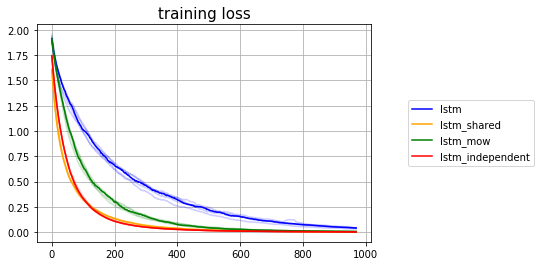

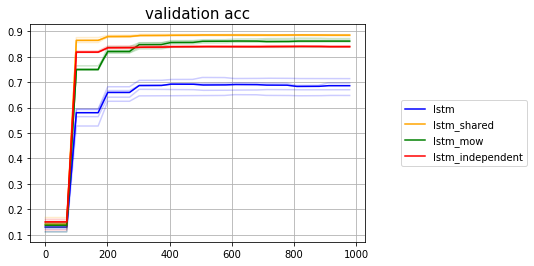

In [46]:
datadir = 'mo_models/scarce_1000/*/'

mlp_models = ['mlp.p*',
              'mlp_shared.p*',
              'mlp_mow*.p*',
              'mlp_independent.p*']
rnn_models = ['lstm.p*',
              'lstm_shared.p**',
              'lstm_mow*.p*',
              'lstm_independent.p*']
mlp_models = [os.path.join(datadir, m) for m in mlp_models]
rnn_models = [os.path.join(datadir, m) for m in rnn_models]


plot_train_val_multiple(rnn_models) 

In [93]:
from collections import defaultdict
def get_datasizes(data_dir_prefix):
    data_sizes = []
    for fn in glob.glob(data_dir_prefix + '_*/'):
        data_sizes.append(int(fn.split('_')[-1][:-1]))
    return sorted(data_sizes)

def plot_datasize(data_dir_prefix, patterns, fontsize=15, colors=['blue', 'orange', 'green', 'red',
                                                                  'purple', 'brown', 'pink', 'gray']):
    sizes = get_datasizes(data_dir_prefix)
    result = defaultdict(list)
    names = [p.split('*')[0].split('/')[-1]for p in patterns]
    for size in sizes:
        for i, pattern in enumerate(patterns):
            pattern = data_dir_prefix + ("_%d/*/" % size) + pattern
            for cpt_fn in glob.glob(pattern):
                cpt = torch.load(cpt_fn)
                name = names[i]
                val_acc = cpt['val_accs'][-1]
                result[name].append((size, val_acc))
                
    for i, k in enumerate(names):
        v = result[k]
        xs = list(map(lambda x: x[0], v))
        ys = list(map(lambda x: x[1], v))
        plt.scatter(xs, ys, label=k, color=colors[i])
        
    plt.legend()
    plt.xlabel('datasize', fontsize=fontsize)
    plt.ylabel('validation accuracy', fontsize=fontsize)
    plt.show()

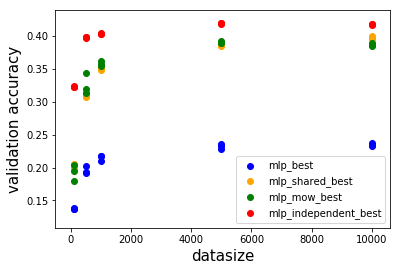

In [96]:
data_dir_prefix = 'mo_models/partial_sum'

mlp_models = ['mlp_best*',
              'mlp_shared_best*',
              'mlp_mow*_best*',
              'mlp_independent_best*']
rnn_models = ['lstm_best*',
              'lstm_shared_best**',
              'lstm_mow*_best*',
              'lstm_independent_best*']

plot_datasize(data_dir_prefix, mlp_models)

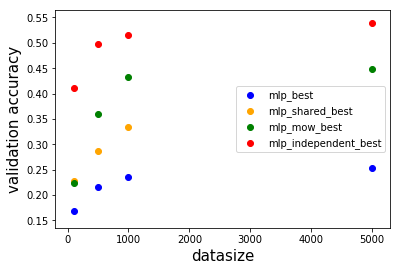

In [97]:
data_dir_prefix = 'mo_models/partial_sum2'

mlp_models = ['mlp_best*',
              'mlp_shared_best*',
              'mlp_mow_best*',
              'mlp_independent_best*']
rnn_models = ['lstm_best*',
              'lstm_shared_best**',
              'lstm_mow_best*',
              'lstm_independent_best*']

plot_datasize(data_dir_prefix, mlp_models)